# Как выбирать размер выборки

*Подготовил Ян Пиле*

Часто, когда собираются проводить АБ-тест, процесс происходит следующим образом:
    
1) К вам приходит менеджер и говорит: "Хочу провести АБ с нововведением Х и увеличить тем самым метрику Y" (например $X = \text{новый алгоритм ранжирования в ленте новостей}$, а $Y = CTR$\)

2) "А какой размер эффекта мы хотим увидеть?"-, спрашиваете Вы.

3) "Какой будет, такой и хотим увидеть,"- отвечает менеджер

Естественно, так ничего не заработает :) Очевидно вы понимаете, что для измерения любого сколь угодно малого эффекта вам нужно иметь бесконечное количество пользователей и, вероятно, бесконечное время проводить эксперимент.

Так что же, в итоге, делать?

# Калькуляторы размеров выборки

In [4]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

In [5]:
# Это мы в Clickhouse ходить будем
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

Вероятно для оценки размера выборки вы видели вот такую формулу.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

<img src = "https://alexanderdyakonov.files.wordpress.com/2019/05/d0b01.jpg?w=700">

Где здесь какая ошибка?

In [6]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

# Как на самом деле сосчитать размер выборки. 

## Допустим, мы считаем наш CTR

[График про CTR](https://redash.lab.karpov.courses/queries/16866/source?p_date=2021-11-10--2021-11-10&p_exp_groups=%5B%222%22%2C%221%22%2C%223%22%2C%224%22%5D#35508)

[График про views](https://redash.lab.karpov.courses/queries/16866/source?p_date=2021-11-08--2021-11-14&p_exp_groups=%5B%222%22%2C%221%22%2C%223%22%2C%224%22%5D#35508)

In [9]:
q = """
select views, count() as users
from (select  
    exp_group,
    user_id,
    sum(action = 'view') as views
from simulator_20240620.feed_actions 
where toDate(time) between '2024-05-31' and '2024-06-06'
    and exp_group in (0,1,2,3,4)
group by exp_group, user_id
)
group by views
order by views
"""


views_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [10]:
views_distribution.head()

,views,users
0,1,11
1,2,9
2,3,3
3,4,4
4,5,22


In [11]:
views_distribution.users.sum()

49814

In [12]:
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()

In [13]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
13,14,637,0.012788
15,16,616,0.012366
14,15,606,0.012165
32,33,602,0.012085
33,34,597,0.011985
...,...,...,...
271,273,1,0.000020
279,282,1,0.000020
273,275,1,0.000020
277,280,1,0.000020


In [2]:
import seaborn as sns

<AxesSubplot:xlabel='views', ylabel='Count'>

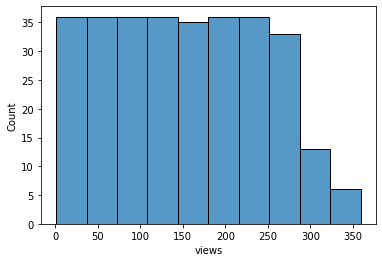

In [14]:
sns.histplot(views_distribution.views)

## Вот наше настоящее распределение просмотров

In [15]:
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [21]:
views_distr

In [16]:
views_distr.mean()

67.11753723852732

In [17]:
views_distr.median()

57.0

In [18]:
views_distr.std()

45.637087804362665

<AxesSubplot:ylabel='Count'>

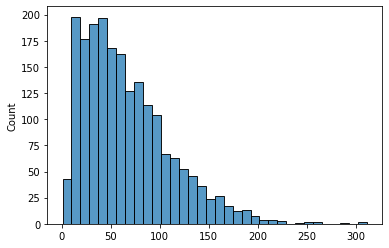

In [19]:
sns.histplot(views_distr.rvs(size=2000))

У $CTR$ разброс где-то от 0.2 до 0.22 по дням. Запомним это)

Достанем распределение CTR'ов за неделю

In [24]:
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240620.feed_actions 
where dt between '2024-05-31' and '2024-06-06'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
)
group by ctr
"""


ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [25]:
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
21,0.20,4977,0.051662
57,0.25,4298,0.044614
39,0.16,4111,0.042673
6,0.18,4015,0.041676
83,0.21,3799,0.039434
...,...,...,...
69,0.74,1,0.000010
9,0.91,1,0.000010
58,0.95,1,0.000010
47,0.87,1,0.000010


In [26]:
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']
distrib = stats.rv_discrete(values=(range(len(probabilities)), probabilities))

def get_ctrs(x, y, distrib, values):
    idx = distrib.rvs(size=x*y)
    result = values[idx]
    return np.array(result).reshape(x,y)

get_ctrs(2000, 2000, distrib, values)

In [29]:
#Функция вернет двумерный массив размером 2000x2000,
# заполненный значениями CTR,
# выбранными на основе их вероятностей в распределении distrib.
get_ctrs(2000, 2000, distrib, values)

array([[0.27, 0.1 , 0.24, ..., 0.27, 0.26, 0.22],
       [0.29, 0.23, 0.35, ..., 0.21, 0.2 , 0.61],
       [0.25, 0.  , 0.18, ..., 0.22, 0.05, 0.24],
       ...,
       [0.3 , 0.17, 0.29, ..., 0.12, 0.2 , 0.32],
       [0.11, 0.18, 0.1 , ..., 0.16, 0.14, 0.22],
       [0.26, 0.3 , 0.23, ..., 0.33, 0.22, 0.25]])

Так, средний CTR у нас был 0.21. допустим, мы хотим замечать изменение на 0.01 (то есть это на 5%)

# Синтетический А-А тест

In [34]:
q = """
select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240620.feed_actions 
where dt between '2024-05-31' and '2024-06-06'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
"""

std = pandahouse.read_clickhouse(q, connection=connection)
std

,dt,exp_group,user_id,ctr
0,2024-06-02,3,25369,0.339286
1,2024-06-04,0,130147,0.375000
2,2024-06-02,3,109043,0.290323
3,2024-06-05,0,17080,0.187500
4,2024-06-06,2,127246,0.275862
...,...,...,...,...
96333,2024-06-02,0,110295,0.210526
96334,2024-06-01,1,129938,0.160000
96335,2024-06-01,1,5051,0.133333
96336,2024-06-05,2,29013,0.166667


In [36]:
np.std(std.ctr)

nan

In [31]:
compute_sample_size_abs(0.1, std, std)

C:\Users\ACER\AppData\Local\Temp\ipykernel_15384\855986593.py:7: RuntimeWarning: invalid value encountered in double_scalars
  z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)


ValueError: cannot convert float NaN to integer

In [20]:
group_A_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_B_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_A_ctr = get_ctrs(2000, 2000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000,2000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [21]:
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: stats.ttest_ind(
        x[0], x[1], equal_var=False).pvalue, zip(a, b)))
    return np.array(result)

In [22]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.8155

In [23]:
t_test(clicks_A, clicks_B).shape

(2000,)

In [24]:
def mannwhitney(a, b):
    """
    Считает p-value для теста Манна-Уитни с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value теста Манна-Уитни для всего списка экспериментов
    """
    result = list(map(lambda x: stats.mannwhitneyu(
        x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [25]:
np.sum(mannwhitney(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.7905

# Бакетное преобразование

In [26]:
def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int32)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return values_0, values_1

In [27]:
# t-тест поверх бакетов
def t_test_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return t_test(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

# тест Манна-Уитни поверх бакетов
def mannwhitney_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return mannwhitney(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

In [28]:
p_values_ab = mannwhitney_buckets(
        clicks_A/group_A_views, group_A_views,
        clicks_B/group_B_views, group_B_views)

In [29]:
np.sum(p_values_ab<= 0.05)/2000

0.722

# Линеаризация

In [30]:
group_A_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_B_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_A_ctr = get_ctrs(2000, 2000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000, 2000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [31]:
control_ctr = stats.binom.rvs(group_B_views, group_B_ctr).sum(axis = 1)/group_B_views.sum(axis = 1)

In [32]:
linearized_A = clicks_A - (group_A_views.T*control_ctr).T
linearized_B = clicks_B - (group_B_views.T*control_ctr).T

In [33]:
linearization_p_values = t_test(linearized_A, linearized_B)

In [34]:
sum(linearization_p_values<=0.05)/2000

0.7605

# А на самом деле просмотры обычно выглядят не так...

In [35]:
mu = 1
sigma2 = 1.5
N = 1447
experiments = 1000
views_lognormal = np.absolute(np.exp(norm(mu, sigma2).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)

Text(0.5, 1.0, 'Views, 99%-ile = 89.0   ')

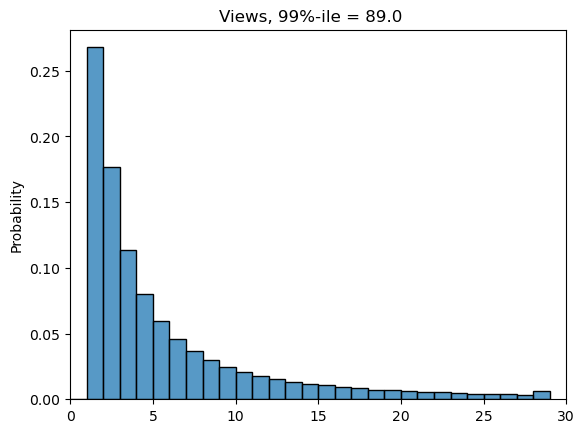

In [36]:
fig = plt.figure()
ax_views = fig.add_subplot()
views_distr = sns.histplot(views_lognormal.ravel(),  # Теперь это массив длины experiments * N
                           bins=range(0, 30),
                           kde=False,
                           ax=ax_views,
                           stat='probability')
ax_views.set_xlim((0, 30))
views_99_percentile = np.percentile(views_lognormal.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')

In [37]:
def get_views(experiments, N, mu = 1, sigma = 1.5):
    views_lognormal = np.absolute(
        np.exp(
            norm(mu, 
                 sigma2).rvs(experiments * N)
        ).astype(np.int64).reshape(experiments, N) + 1)
    return views_lognormal

In [38]:
group_A_views = get_views(2000, 11000).astype("int32")
group_B_views = get_views(2000, 11000).astype("int32")
group_A_ctr = get_ctrs(2000, 11000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000, 11000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [39]:
compute_sample_size_abs(0.01, 0.278, 0.278)

12132

In [40]:
(clicks_B/group_B_views).std(axis = 1)[0]

0.2825018701218114

In [41]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.7925

In [42]:
np.sum(t_test_buckets(clicks_A/group_A_views, 
                      group_A_views,
                      clicks_B/group_B_views, 
                      group_B_views)<= 0.05)/2000

0.812

# А если я хочу сдвинуть медиану ...

In [43]:
def bucketization_median(ctrs_0, ctrs_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int32)
        values_0[:, b] = np.median(ctrs_0[:, ind], axis=1)
        values_1[:, b] = np.median(ctrs_1[:, ind], axis=1)

    return values_0, values_1

In [44]:
def mannwhitney_median_buckets(ctrs_0, ctrs_1, n_buckets=100):
    return mannwhitney(*bucketization_median(ctrs_0, ctrs_1, n_buckets))

In [45]:
np.sum(mannwhitney_median_buckets(clicks_A/group_A_views,clicks_B/group_B_views)<= 0.05) /2000

0.633